In [31]:
library(dplyr)
library(tidyverse)
library(lubridate)
library(caret)
library(zoo)
library(xgboost)
library(gbm)
library(glmnet)
library(Metrics)
library(forecast)
library(tseries)

In [8]:
# Load datasets
features <- read.csv("features.csv")
stores <- read.csv("stores.csv")
train <- read.csv("train.csv")
test <- read.csv("test.csv")

In [9]:
# Convert Date columns to Date type
features$Date <- as.Date(features$Date, format="%Y-%m-%d")
test$Date <- as.Date(test$Date, format="%Y-%m-%d")
train$Date <- as.Date(train$Date, format="%Y-%m-%d")

### Analyze Weekly Sales Trend

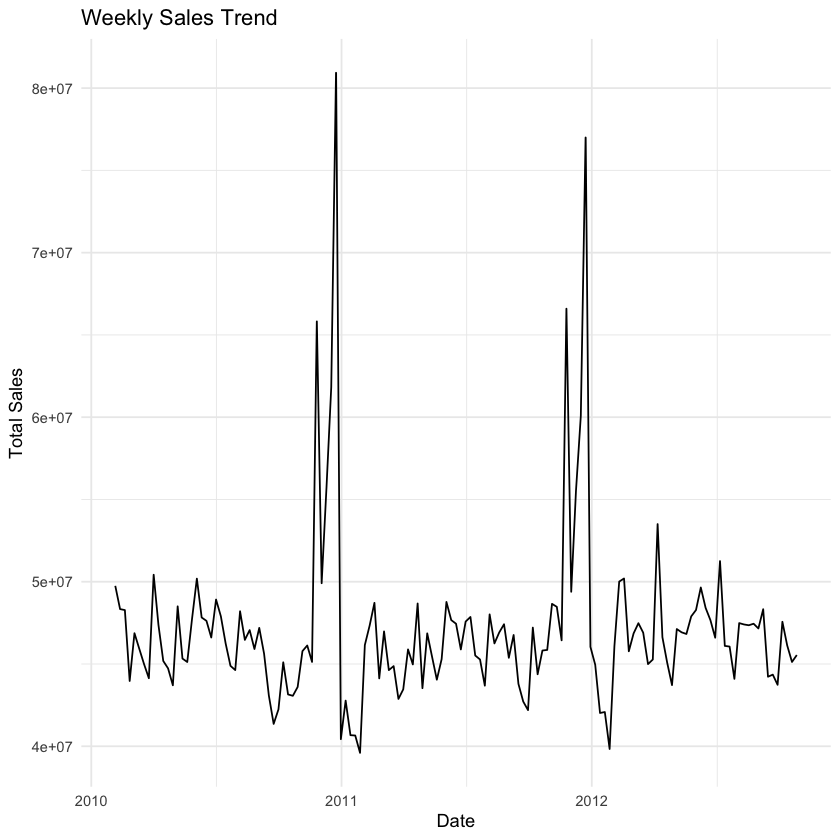

In [10]:
# Aggregate weekly sales for trend analysis
sales_trend <- train |>
  group_by(Date) |>
  summarize(Total_sales = sum(Weekly_Sales))

# PLot the sales trend
sales_trend |>
  ggplot(aes(x = Date, y = Total_sales)) +
  geom_line() +
  labs(
    title = "Weekly Sales Trend",
    x = "Date",
    y = "Total Sales"
  ) +
  theme_minimal()

### Analyze Seasonality

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


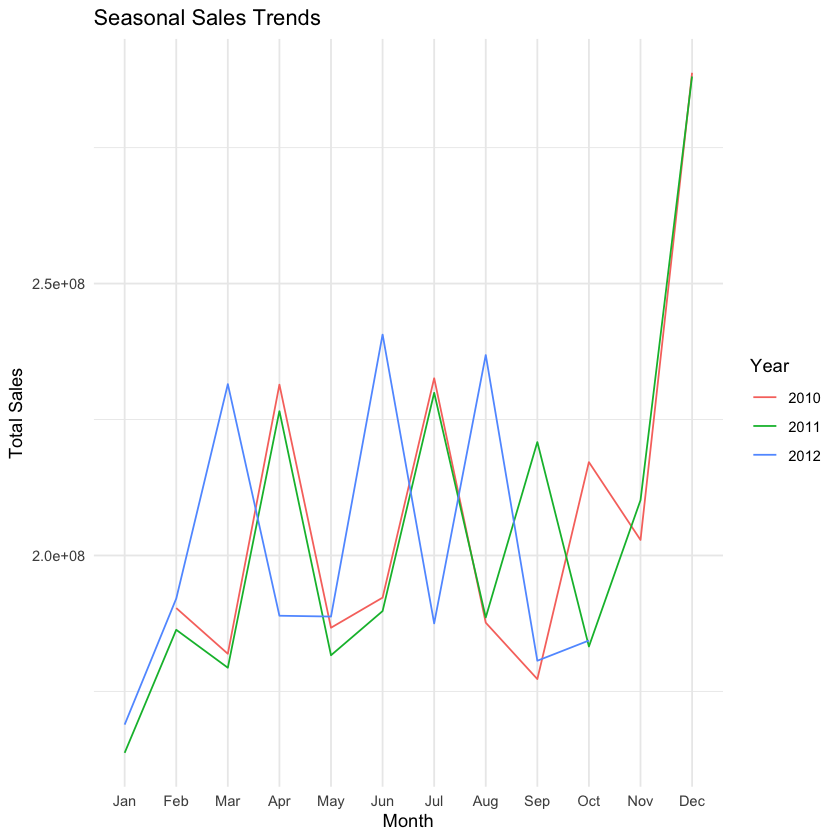

In [11]:
# Extract year and month
train <- train |>
    mutate(Year = year(Date), Month = month(Date, label = TRUE))

# Aggregate sales by month
monthly_sales <- train |>
    group_by(Year, Month) |>
    summarize(Total_Sales = sum(Weekly_Sales))

# Plot seasonal trends
monthly_sales |>
    ggplot(aes(x = Month, y = Total_Sales, group = Year, color = as.factor(Year))) +
    geom_line() +
    labs(
        title = "Seasonal Sales Trends",
        x = "Month",
        y = "Total Sales",
        color = "Year"
    ) +
    theme_minimal()

### Handle Missing Values in Features Dataset

In [12]:
# Check for missing values
missing_values <- colSums(is.na(features))
print(missing_values)

       Store         Date  Temperature   Fuel_Price    MarkDown1    MarkDown2 
           0            0            0            0         4158         5269 
   MarkDown3    MarkDown4    MarkDown5          CPI Unemployment    IsHoliday 
        4577         4726         4140          585          585            0 


In [13]:
# Replace missing values with median or a placeholder (if needed)
features <- features %>%
  mutate(across(starts_with("MarkDown"), ~ ifelse(is.na(.), median(., na.rm = TRUE), .)),
         CPI = ifelse(is.na(CPI), median(CPI, na.rm = TRUE), CPI),
         Unemployment = ifelse(is.na(Unemployment), median(Unemployment, na.rm = TRUE), Unemployment))

### Identify Sales Distributions Across Stores

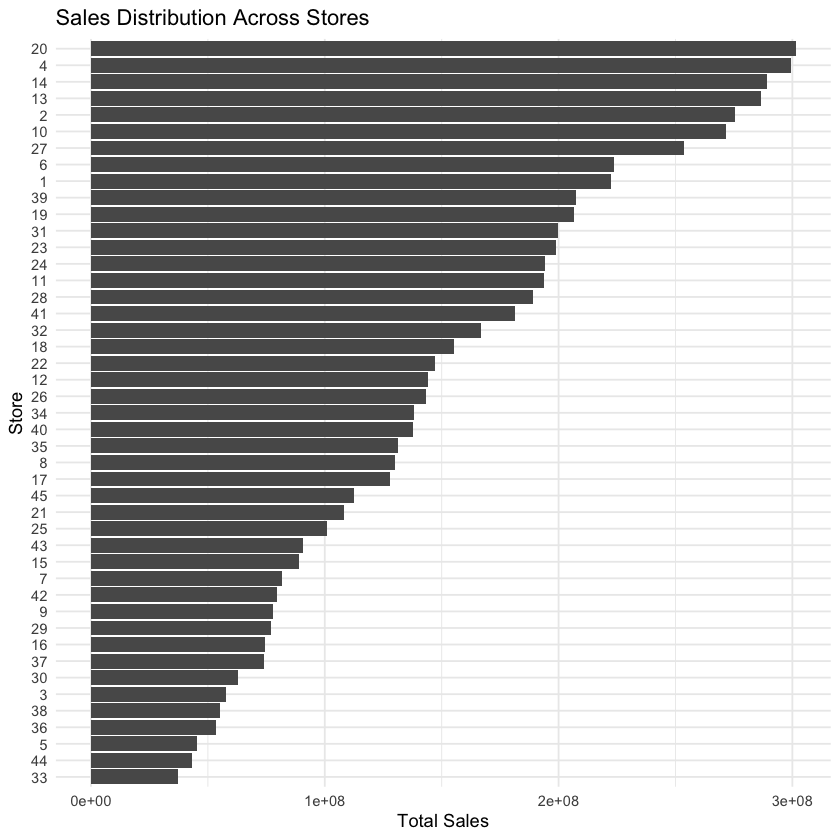

In [14]:
# Aggregate sales by store
store_sales <- train |>
    group_by(Store) |>
    summarize(Total_Sales = sum(Weekly_Sales))

# Plot sales distribution
store_sales |>
    ggplot(aes(x = reorder(as.factor(Store), Total_Sales), y = Total_Sales)) +
    geom_bar(stat = "identity") +
    labs(
        title = "Sales Distribution Across Stores",
        x = "Store",
        y = "Total Sales"
    ) +
    theme_minimal() +
    coord_flip()

### Merge Datasets for Analysis

In [15]:
train_combined <- train |>
    left_join(features, by = c("Store", "Date")) |>
    left_join(stores, by = "Store")

train_combined <- train_combined[, !names(train_combined) %in% "IsHoliday.x"]
names(train_combined)[names(train_combined) == "IsHoliday.y"] <- "IsHoliday"

test_combined <- test |>
    left_join(features, by = c("Store", "Date")) |>
    left_join(stores, by = "Store")

test_combined <- test_combined[, !names(test_combined) %in% "IsHoliday.x"]
names(test_combined)[names(test_combined) == "IsHoliday.y"] <- "IsHoliday"

head(train_combined)
head(test_combined)

,Store,Dept,Date,Weekly_Sales,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
,<int>,<int>,<date>,<dbl>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>
1,1,1,2010-02-05,24924.50,2010,Feb,42.31,2.572,4743.58,364.57,36.26,1176.425,2727.135,211.0964,8.106,FALSE,A,151315
2,1,1,2010-02-12,46039.49,2010,Feb,38.51,2.548,4743.58,364.57,36.26,1176.425,2727.135,211.2422,8.106,TRUE,A,151315
3,1,1,2010-02-19,41595.55,2010,Feb,39.93,2.514,4743.58,364.57,36.26,1176.425,2727.135,211.2891,8.106,FALSE,A,151315
4,1,1,2010-02-26,19403.54,2010,Feb,46.63,2.561,4743.58,364.57,36.26,1176.425,2727.135,211.3196,8.106,FALSE,A,151315
5,1,1,2010-03-05,21827.90,2010,Mar,46.50,2.625,4743.58,364.57,36.26,1176.425,2727.135,211.3501,8.106,FALSE,A,151315
6,1,1,2010-03-12,21043.39,2010,Mar,57.79,2.667,4743.58,364.57,36.26,1176.425,2727.135,211.3806,8.106,FALSE,A,151315


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>
1,1,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.4628,6.573,FALSE,A,151315
2,1,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.4813,6.573,FALSE,A,151315
3,1,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.5129,6.573,FALSE,A,151315
4,1,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.5619,6.573,TRUE,A,151315
5,1,1,2012-11-30,52.34,3.207,2460.03,364.57,3838.35,150.57,6966.34,223.6110,6.573,FALSE,A,151315
6,1,1,2012-12-07,64.12,3.198,6343.16,364.57,270.00,2928.90,10147.90,223.6600,6.573,FALSE,A,151315


### Feature Engineering

In [16]:
feature_engineering <- function(data, scaling_params = NULL, is_test = FALSE) {
  # Add basic date-based features
  data <- data %>%
    mutate(
      Year = year(Date),
      Month = month(Date, label = TRUE),
      Day_of_Week = wday(Date, label = TRUE),
      Is_Weekend = ifelse(Day_of_Week %in% c("Sat", "Sun"), TRUE, FALSE)
    )
  
  # Add pre-holiday and post-holiday indicators
  data <- data %>%
    mutate(
      Pre_Holiday = ifelse(lag(IsHoliday, n = 1, default = FALSE), TRUE, FALSE),
      Post_Holiday = ifelse(lead(IsHoliday, n = 1, default = FALSE), TRUE, FALSE)
    )
  
  # Add seasonal indicators (e.g., summer, winter)
  data <- data %>%
    mutate(
      Season = case_when(
        Month %in% c("Dec", "Jan", "Feb") ~ "Winter",
        Month %in% c("Mar", "Apr", "May") ~ "Spring",
        Month %in% c("Jun", "Jul", "Aug") ~ "Summer",
        Month %in% c("Sep", "Oct", "Nov") ~ "Fall",
        TRUE ~ "Unknown"
      )
    )
  
  # Add lagged and rolling averages for Weekly_Sales for training data only
  if (!is_test && "Weekly_Sales" %in% colnames(data)) {
    data <- data %>%
      group_by(Store, Dept) %>%
      mutate(
        Lag_1_Week_Sales = lag(Weekly_Sales, n = 1),
        Rolling_4_Week_Sales = rollmean(Weekly_Sales, k = 4, fill = NA, align = "right")
      ) %>%
      ungroup()
  }
  
  # Encode categorical variables (Month, Day_of_Week, Type, Season)
  data <- data %>%
    mutate(
      Month_Encoded = as.numeric(as.factor(Month)),
      Day_of_Week_Encoded = as.numeric(as.factor(Day_of_Week)),
      Type_Encoded = as.numeric(as.factor(Type)),
      Season_Encoded = as.numeric(as.factor(Season))
    )
  
  # Scale numeric features (Temperature, Fuel_Price, CPI, Unemployment)
  if (is.null(scaling_params)) {
    # Compute scaling parameters (mean and sd) from the training data
    scaling_params <- data %>%
      summarise(
        Temperature_Mean = mean(Temperature, na.rm = TRUE),
        Temperature_SD = sd(Temperature, na.rm = TRUE),
        Fuel_Price_Mean = mean(Fuel_Price, na.rm = TRUE),
        Fuel_Price_SD = sd(Fuel_Price, na.rm = TRUE),
        CPI_Mean = mean(CPI, na.rm = TRUE),
        CPI_SD = sd(CPI, na.rm = TRUE),
        Unemployment_Mean = mean(Unemployment, na.rm = TRUE),
        Unemployment_SD = sd(Unemployment, na.rm = TRUE)
      )
  }
  
  # Apply scaling
  data <- data %>%
    mutate(
      Temperature_Scaled = (Temperature - scaling_params$Temperature_Mean) / scaling_params$Temperature_SD,
      Fuel_Price_Scaled = (Fuel_Price - scaling_params$Fuel_Price_Mean) / scaling_params$Fuel_Price_SD,
      CPI_Scaled = (CPI - scaling_params$CPI_Mean) / scaling_params$CPI_SD,
      Unemployment_Scaled = (Unemployment - scaling_params$Unemployment_Mean) / scaling_params$Unemployment_SD
    )
  
  return(list(data = data, scaling_params = scaling_params))
}

# Apply feature engineering to training data
train_features <- feature_engineering(train_combined)

# Save scaling parameters for the test data
scaling_params <- train_features$scaling_params

# Apply feature engineering to test data
test_features <- feature_engineering(test_combined, scaling_params = scaling_params, is_test = TRUE)

# Extract processed dataframes
processed_train <- train_features$data
processed_test <- test_features$data


In [17]:
head(processed_train)
head(processed_test)


Store,Dept,Date,Weekly_Sales,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Lag_1_Week_Sales,Rolling_4_Week_Sales,Month_Encoded,Day_of_Week_Encoded,Type_Encoded,Season_Encoded,Temperature_Scaled,Fuel_Price_Scaled,CPI_Scaled,Unemployment_Scaled
<int>,<int>,<date>,<dbl>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2010-02-05,24924.50,2010,Feb,42.31,2.572,4743.58,364.57,...,NA,NA,2,6,1,4,-0.9637969,-1.720832,1.018773,0.07820083
1,1,2010-02-12,46039.49,2010,Feb,38.51,2.548,4743.58,364.57,...,24924.50,NA,2,6,1,4,-1.1697821,-1.773175,1.022497,0.07820083
1,1,2010-02-19,41595.55,2010,Feb,39.93,2.514,4743.58,364.57,...,46039.49,NA,2,6,1,4,-1.0928087,-1.847328,1.023696,0.07820083
1,1,2010-02-26,19403.54,2010,Feb,46.63,2.561,4743.58,364.57,...,41595.55,32990.77,2,6,1,4,-0.7296243,-1.744823,1.024475,0.07820083
1,1,2010-03-05,21827.90,2010,Mar,46.50,2.625,4743.58,364.57,...,19403.54,32216.62,3,6,1,2,-0.7366712,-1.605241,1.025254,0.07820083
1,1,2010-03-12,21043.39,2010,Mar,57.79,2.667,4743.58,364.57,...,21827.90,25967.59,3,6,1,2,-0.1246784,-1.513641,1.026033,0.07820083


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Post_Holiday,Season,Month_Encoded,Day_of_Week_Encoded,Type_Encoded,Season_Encoded,Temperature_Scaled,Fuel_Price_Scaled,CPI_Scaled,Unemployment_Scaled
,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,...,FALSE,Fall,11,6,1,1,-0.25856876,0.05446604,1.334571,-0.7445348
2,1,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,...,FALSE,Fall,11,6,1,1,0.06233443,-0.10256278,1.335044,-0.7445348
3,1,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,...,TRUE,Fall,11,6,1,1,-0.38866465,-0.23778205,1.335851,-0.7445348
4,1,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,...,FALSE,Fall,11,6,1,1,-0.20924074,-0.32720124,1.337103,-0.7445348
5,1,1,2012-11-30,52.34,3.207,2460.03,364.57,3838.35,150.57,6966.34,...,FALSE,Fall,11,6,1,1,-0.42010449,-0.33592507,1.338356,-0.7445348
6,1,1,2012-12-07,64.12,3.198,6343.16,364.57,270.00,2928.90,10147.90,...,FALSE,Winter,12,6,1,4,0.21844950,-0.35555367,1.339608,-0.7445348


In [18]:
names(processed_train)

[1] "Store"                "Dept"                 "Date"                
 [4] "Weekly_Sales"         "Year"                 "Month"               
 [7] "Temperature"          "Fuel_Price"           "MarkDown1"           
[10] "MarkDown2"            "MarkDown3"            "MarkDown4"           
[13] "MarkDown5"            "CPI"                  "Unemployment"        
[16] "IsHoliday"            "Type"                 "Size"                
[19] "Day_of_Week"          "Is_Weekend"           "Pre_Holiday"         
[22] "Post_Holiday"         "Season"               "Lag_1_Week_Sales"    
[25] "Rolling_4_Week_Sales" "Month_Encoded"        "Day_of_Week_Encoded" 
[28] "Type_Encoded"         "Season_Encoded"       "Temperature_Scaled"  
[31] "Fuel_Price_Scaled"    "CPI_Scaled"           "Unemployment_Scaled"

In [19]:
names(processed_test)

[1] "Store"               "Dept"                "Date"               
 [4] "Temperature"         "Fuel_Price"          "MarkDown1"          
 [7] "MarkDown2"           "MarkDown3"           "MarkDown4"          
[10] "MarkDown5"           "CPI"                 "Unemployment"       
[13] "IsHoliday"           "Type"                "Size"               
[16] "Year"                "Month"               "Day_of_Week"        
[19] "Is_Weekend"          "Pre_Holiday"         "Post_Holiday"       
[22] "Season"              "Month_Encoded"       "Day_of_Week_Encoded"
[25] "Type_Encoded"        "Season_Encoded"      "Temperature_Scaled" 
[28] "Fuel_Price_Scaled"   "CPI_Scaled"          "Unemployment_Scaled"

In [20]:
# Get the column names of the test dataset
test_features <- colnames(processed_test)

# Reorder the training dataset to match the test dataset
processed_train <- processed_train %>%
  select(all_of(test_features), Weekly_Sales)

### Convert Data to Numerical, Feature Selection

In [21]:
preprocess_data <- function(data, is_train = TRUE) {
  # Convert logical columns to numeric
  data <- data %>%
    mutate(
      IsHoliday = as.numeric(IsHoliday),
      Is_Weekend = as.numeric(Is_Weekend),
      Pre_Holiday = as.numeric(Pre_Holiday),
      Post_Holiday = as.numeric(Post_Holiday)
    )
  
  # Encode categorical columns
  data <- data %>%
    mutate(
      Type = as.numeric(as.factor(Type)), 
      Season = as.numeric(as.factor(Season))  
    )
  
  # Convert ordinal columns to numeric
  data <- data %>%
    mutate(
      Month = as.numeric(Month), 
      Day_of_Week = as.numeric(Day_of_Week)  
    )
  
  # Conditionally remove the Date column
  if ("Date" %in% colnames(data)) {
    data <- data %>% select(-Date)
  }
  
  # Exclude target variable for test dataset
  if (!is_train && "Weekly_Sales" %in% colnames(data)) {
    data <- data %>% select(-Weekly_Sales)
  }
  
  return(data)
}

In [22]:
processed_train <- preprocess_data(processed_train, is_train = TRUE)
processed_test <- preprocess_data(processed_test, is_train = FALSE)

In [23]:
names(processed_test)

[1] "Store"               "Dept"                "Temperature"        
 [4] "Fuel_Price"          "MarkDown1"           "MarkDown2"          
 [7] "MarkDown3"           "MarkDown4"           "MarkDown5"          
[10] "CPI"                 "Unemployment"        "IsHoliday"          
[13] "Type"                "Size"                "Year"               
[16] "Month"               "Day_of_Week"         "Is_Weekend"         
[19] "Pre_Holiday"         "Post_Holiday"        "Season"             
[22] "Month_Encoded"       "Day_of_Week_Encoded" "Type_Encoded"       
[25] "Season_Encoded"      "Temperature_Scaled"  "Fuel_Price_Scaled"  
[28] "CPI_Scaled"          "Unemployment_Scaled"

In [24]:
names(processed_train)

[1] "Store"               "Dept"                "Temperature"        
 [4] "Fuel_Price"          "MarkDown1"           "MarkDown2"          
 [7] "MarkDown3"           "MarkDown4"           "MarkDown5"          
[10] "CPI"                 "Unemployment"        "IsHoliday"          
[13] "Type"                "Size"                "Year"               
[16] "Month"               "Day_of_Week"         "Is_Weekend"         
[19] "Pre_Holiday"         "Post_Holiday"        "Season"             
[22] "Month_Encoded"       "Day_of_Week_Encoded" "Type_Encoded"       
[25] "Season_Encoded"      "Temperature_Scaled"  "Fuel_Price_Scaled"  
[28] "CPI_Scaled"          "Unemployment_Scaled" "Weekly_Sales"

In [25]:
str(processed_train)

tibble [421,570 x 30] (S3: tbl_df/tbl/data.frame)
 $ Store              : int [1:421570] 1 1 1 1 1 1 1 1 1 1 ...
 $ Dept               : int [1:421570] 1 1 1 1 1 1 1 1 1 1 ...
 $ Temperature        : num [1:421570] 42.3 38.5 39.9 46.6 46.5 ...
 $ Fuel_Price         : num [1:421570] 2.57 2.55 2.51 2.56 2.62 ...
 $ MarkDown1          : num [1:421570] 4744 4744 4744 4744 4744 ...
 $ MarkDown2          : num [1:421570] 365 365 365 365 365 ...
 $ MarkDown3          : num [1:421570] 36.3 36.3 36.3 36.3 36.3 ...
 $ MarkDown4          : num [1:421570] 1176 1176 1176 1176 1176 ...
 $ MarkDown5          : num [1:421570] 2727 2727 2727 2727 2727 ...
 $ CPI                : num [1:421570] 211 211 211 211 211 ...
 $ Unemployment       : num [1:421570] 8.11 8.11 8.11 8.11 8.11 ...
 $ IsHoliday          : num [1:421570] 0 1 0 0 0 0 0 0 0 0 ...
 $ Type               : num [1:421570] 1 1 1 1 1 1 1 1 1 1 ...
 $ Size               : int [1:421570] 151315 151315 151315 151315 151315 151315 151315 151315 1

### Data Splitting

In [26]:
set.seed(42)

# Define the split (80% training, 20% validation)
train_indices <- createDataPartition(processed_train$Weekly_Sales, p = 0.8, list = FALSE)

# Split the data
train_set <- processed_train[train_indices, ]
validation_set <- processed_train[-train_indices, ]

# Save the datasets for future use
write.csv(train_set, "train_set.csv", row.names = FALSE)
write.csv(validation_set, "validation_set.csv", row.names = FALSE)

# Verify the split
dim(train_set)
dim(validation_set)


[1] 337258     30

[1] 84312    30

## Models

In [ ]:
control <- trainControl(method = "cv", number = 5)

### Ridge Model

In [32]:
ridge_tuned <- train(
    Weekly_Sales ~ .,
    data = train_set,
    method = "glmnet",
    tuneGrid = expand.grid(alpha = 0, lambda = seq(0.001, 0.5, by = 0.005)),
    trControl = trainControl(method = "cv", number = 5)
)
ridge_valid <- predict(ridge_tuned, newdata = validation_set)

### Lasso Model

In [33]:
# Lasso Regression
lasso_tuned <- train(
    Weekly_Sales ~ .,
    data = train_set,
    method = "glmnet",
    tuneGrid = expand.grid(alpha = 1, lambda = seq(0.001, 0.1, by = 0.01)),
    trControl = trainControl(method = "cv", number = 5)
)

# Predict using Lasso Regression on validation data
lasso_valid <- predict(lasso_tuned, newdata = validation_set)


### XGBoost Model

In [34]:
# Convert features to numeric matrices
train_matrix <- model.matrix(~ . - Weekly_Sales, data = train_set)  # Exclude target
validation_matrix <- model.matrix(~ . - Weekly_Sales, data = validation_set)

# Extract target variable
train_labels <- as.numeric(train_set$Weekly_Sales)

# Create DMatrix
xgb_train <- xgb.DMatrix(data = train_matrix, label = train_labels)
xgb_validation <- xgb.DMatrix(data = validation_matrix)

# Train XGBoost model
xgb_model <- xgboost(
    data = xgb_train,
    nrounds = 100,
    objective = "reg:squarederror",
    verbose = 1
)

# Predict using XGBoost on validation data
xgb_pred <- predict(xgb_model, newdata = xgb_validation)



[1]	train-rmse:21335.744476 
[2]	train-rmse:17237.574310 
[3]	train-rmse:14883.409716 
[4]	train-rmse:13279.528335 
[5]	train-rmse:12269.431195 
[6]	train-rmse:11528.996257 
[7]	train-rmse:10884.250500 
[8]	train-rmse:10270.416924 
[9]	train-rmse:9934.706063 
[10]	train-rmse:9657.998806 
[11]	train-rmse:9418.596176 
[12]	train-rmse:9233.582717 
[13]	train-rmse:9077.881519 
[14]	train-rmse:8808.039812 
[15]	train-rmse:8629.839882 
[16]	train-rmse:8391.557369 
[17]	train-rmse:8288.974449 
[18]	train-rmse:8183.567991 
[19]	train-rmse:7979.523955 
[20]	train-rmse:7893.108600 
[21]	train-rmse:7738.901197 
[22]	train-rmse:7592.189675 
[23]	train-rmse:7459.529323 
[24]	train-rmse:7335.347933 
[25]	train-rmse:7289.715231 
[26]	train-rmse:7198.311405 
[27]	train-rmse:7129.274880 
[28]	train-rmse:7080.606341 
[29]	train-rmse:7033.943766 
[30]	train-rmse:6979.757364 
[31]	train-rmse:6927.399530 
[32]	train-rmse:6854.661539 
[33]	train-rmse:6778.421084 
[34]	train-rmse:6740.593022 
[35]	train-rmse

### Models -- Gradient Boosting

In [35]:
# Gradient Boosting
gbm_tuned <- train(
    Weekly_Sales ~ .,
    data = train_set,
    method = "gbm",
    trControl = trainControl(method = "cv", number = 5),
    verbose = FALSE
)

# Predict using Gradient Boosting on validation data
gbm_validation <- predict(gbm_tuned, newdata = validation_set)


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 17: Day_of_Week has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 18: Is_Weekend has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 23: Day_of_Week_Encoded has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 17: Day_of_Week has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 18: Is_Weekend has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 23: Day_of_Week_Encoded has no variation."
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 17: Day_of_Week has no variation."
Warning messa

### Evaluate Performance on Validation Set

In [36]:
# Define a helper function for evaluation
evaluate_model_performance <- function(actual, predicted) {
    data.frame(
        RMSE = rmse(actual, predicted),
        MAE = mae(actual, predicted),
        R2 = R2(predicted, actual)
    )
}

# Evaluate Ridge Regression
ridge_results <- evaluate_model_performance(validation_set$Weekly_Sales, ridge_valid)

# Evaluate Lasso Regression
lasso_results <- evaluate_model_performance(validation_set$Weekly_Sales, lasso_valid)

# Evaluate Gradient Boosting
gbm_results <- evaluate_model_performance(validation_set$Weekly_Sales, gbm_validation)

# Combine Results into a Comparison Table
model_performance_comparison <- rbind(
    Ridge = ridge_results,
    Lasso = lasso_results,
    GradientBoosting = gbm_results
)

# Print the Comparison Table
print("Model Performance on Validation Data:")
print(model_performance_comparison)


[1] "Model Performance on Validation Data:"
                     RMSE      MAE         R2
Ridge            21818.90 14545.34 0.08928746
Lasso            21817.10 14554.62 0.08932678
GradientBoosting 12461.26  7467.43 0.72377547


### Forecasts

In [37]:
# Generate predictions for Ridge Regression
ridge_test_pred <- predict(ridge_tuned, newdata = processed_test)

# Generate predictions for Lasso Regression
lasso_test_pred <- predict(lasso_tuned, newdata = processed_test)

# Generate predictions for Gradient Boosting
gbm_test_pred <- predict(gbm_tuned, newdata = processed_test)

# Combine predictions into a DataFrame for reporting
test_predictions <- data.frame(
    Ridge = ridge_test_pred,
    Lasso = lasso_test_pred,
    GradientBoosting = gbm_test_pred
)

head(test_predictions)

,Ridge,Lasso,GradientBoosting
,<dbl>,<dbl>,<dbl>
1,11861.73,11584.89,26352.95
2,12284.49,11982.58,26352.95
3,13833.37,13600.09,26352.95
4,20089.47,19903.42,31341.61
5,12220.24,11994.91,29527.40
6,14832.11,14559.71,27106.77


## Forecasting: ARIMA and SARIMA

In [ ]:
train_set <- train_set %>%
  mutate(Year_Month = paste(Year, Month, sep = "-"))

# Aggregate 'Weekly_Sales' by Month
monthly_sales <- train_set %>%
  group_by(Year_Month) %>%
  summarise(Total_Sales = sum(Weekly_Sales, na.rm = TRUE))

# Convert Aggregated Sales to a Time Series
start_year <- as.numeric(substr(monthly_sales$Year_Month[1], 1, 4))
start_month <- as.numeric(substr(monthly_sales$Year_Month[1], 6, 7))

# Convert to time series object
ts_monthly_sales <- ts(monthly_sales$Total_Sales, start = c(start_year, start_month), frequency = 12)


In [ ]:
# Fit ARIMA Model
arima_model <- auto.arima(ts_monthly_sales)
summary(arima_model)

Series: ts_monthly_sales 
ARIMA(0,0,0)(0,1,0)[12] 

sigma^2 = 3.662e+14:  log likelihood = -381.91
AIC=765.81   AICc=766.02   BIC=766.86

Training set error measures:
                   ME     RMSE     MAE        MPE     MAPE      MASE
Training set -1086244 15265012 8164234 -0.9197266 4.993554 0.6410368
                    ACF1
Training set -0.06493152

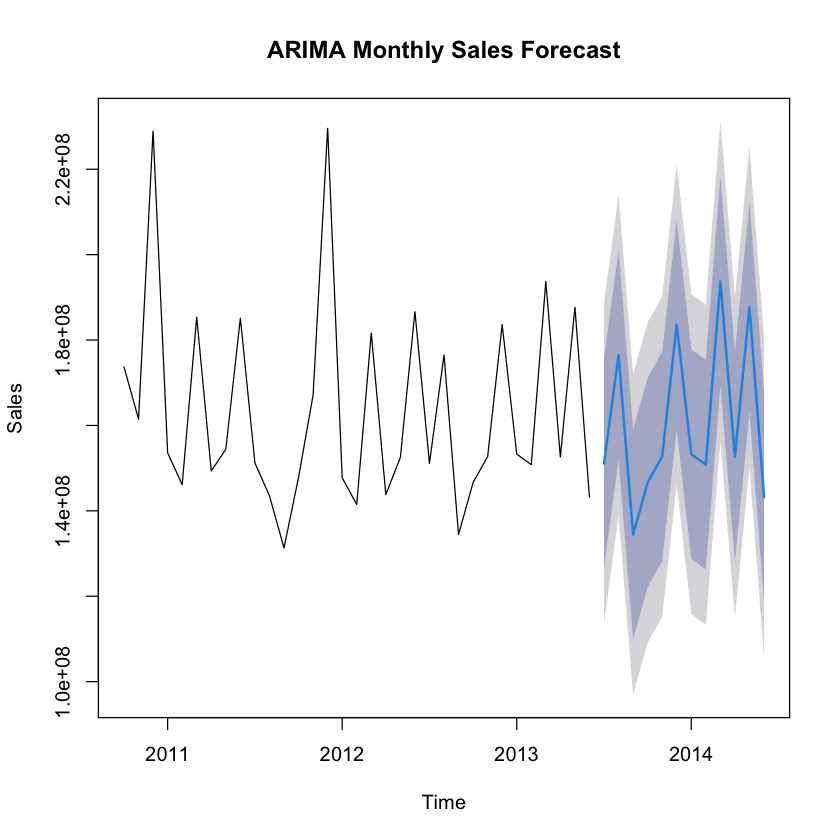

In [ ]:
# Forecast for the Next 12 Months
arima_forecast <- forecast(arima_model, h = 12)

# Plot the Forecast
plot(arima_forecast, main = "ARIMA Monthly Sales Forecast", ylab = "Sales", xlab = "Time")

In [ ]:
# Fit a SARIMA Model
sarima_model <- Arima(
  ts_monthly_sales,
  order = c(1, 1, 1),      
  seasonal = c(1, 1, 1),  
  include.constant = TRUE 
)

# Display the summary of the SARIMA model
summary(sarima_model)

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Series: ts_monthly_sales 
ARIMA(1,1,1)(1,1,1)[12] 

Coefficients:
          ar1     ma1     sar1     sma1
      -0.0174  -1.000  -0.0525  -0.0555
s.e.   0.2689   0.159      NaN      NaN

sigma^2 = 4.68e+14:  log likelihood = -365.59
AIC=741.19   AICc=745.47   BIC=746.16

Training set error measures:
                  ME     RMSE     MAE      MPE     MAPE      MASE        ACF1
Training set 2162682 15063306 8284005 1.100554 4.941711 0.6504409 -0.02357797

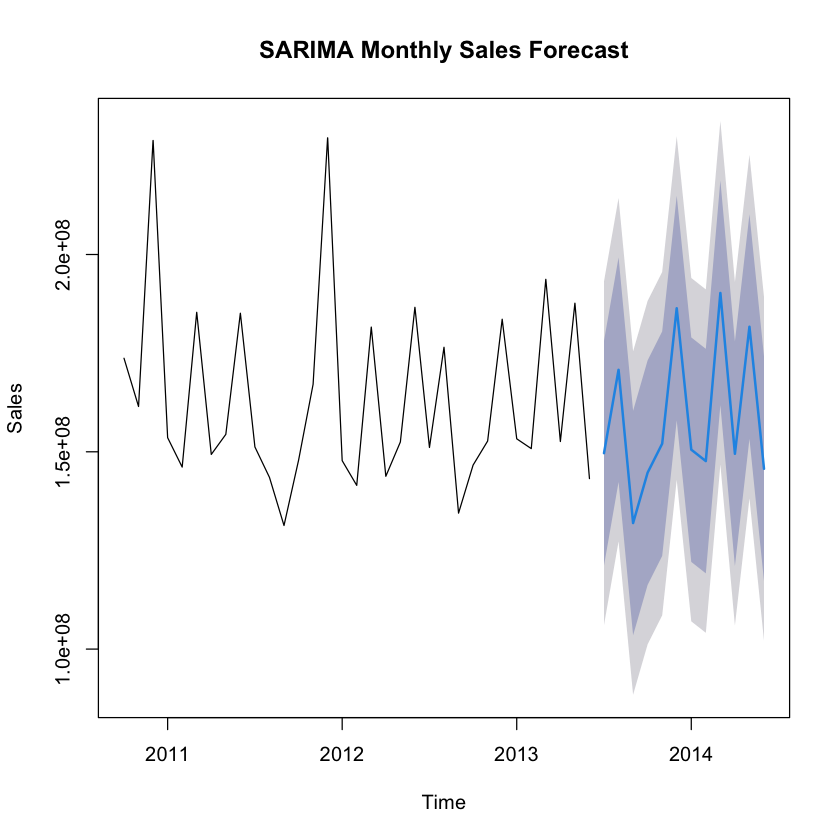

In [ ]:
# Generate a Forecast for the Next 12 Months
sarima_forecast <- forecast(sarima_model, h = 12)

# Plot the SARIMA Forecast
plot(sarima_forecast, main = "SARIMA Monthly Sales Forecast", xlab = "Time", ylab = "Sales")